In [14]:
import re
import pandas as pd

In [15]:
df = pd.read_csv("Interval_Data.csv")
df_extracted = df
df_extracted.head()

,Date,Interval_Price,midpoint
0,2022-07-01,"[135.660004, 139.039993]",137.349998
1,2022-07-05,"[136.929993, 141.610001]",139.269997
2,2022-07-06,"[141.080002, 144.119995]",142.599998
3,2022-07-07,"[143.279999, 146.550003]",144.915001
4,2022-07-08,"[145.0, 147.550003]",146.275002


In [16]:
def str_to_interval(interval_str):
    if not isinstance(interval_str, str):
        return interval_str
    numbers = re.findall(r"[-+]?\d*\.\d+|\d+", interval_str)
    if len(numbers) == 2:
        return pd.Interval(float(numbers[0]), float(numbers[1]))
    return None

df_extracted['Interval_Price'] = df_extracted['Interval_Price'].apply(str_to_interval)
# Remove '[]' and split the interval range into two columns 'Low' and 'High'
# df_extracted[['Low', 'High']] = df_extracted['Interval_Price'].str.strip('[]').str.split('-', expand=True)

df_extracted['Low'] = df_extracted['Interval_Price'].apply(lambda x: x.left)
df_extracted['High'] = df_extracted['Interval_Price'].apply(lambda x: x.right)
df_extracted['Mid'] = df_extracted['Interval_Price'].apply(lambda x: (x.left + x.right) / 2)

# Convert 'Low' and 'High' to numeric, and calculate the 'Mid' from 'Low' and 'High'.
# df_extracted['Low'] = pd.to_numeric(df_extracted['Low'])
# df_extracted['High'] = pd.to_numeric(df_extracted['High'])
# df_extracted['Mid'] = pd.to_numeric(df_extracted['midpoint'])

df_extracted = df_extracted.drop(columns=['Interval_Price','midpoint'])
df_extracted.head()

,Date,Low,High,Mid
0,2022-07-01,135.660004,139.039993,137.349998
1,2022-07-05,136.929993,141.610001,139.269997
2,2022-07-06,141.080002,144.119995,142.599998
3,2022-07-07,143.279999,146.550003,144.915001
4,2022-07-08,145.000000,147.550003,146.275002


In [17]:

data = pd.read_csv("AAPL.csv")
#     Split data for training

def train_test_split(data, prediction_size):
    train_size = int(len(data) * (1-prediction_size))
    train = pd.DataFrame(data[0:train_size])
    test = pd.DataFrame(data[train_size:len(data)])
    return train, test

In [21]:
from pmdarima import auto_arima
# 这里假设数据在 'stock_data.csv' 文件中，我们将其读取为 DataFrame
# 由于你的数据是中文的，可能需要制定encoding为'utf-8'
# data = pd.read_csv('AAPL.csv', encoding='utf-8')
# data = df_extracted


data = pd.DataFrame(df_extracted[['Low']])

# 将 'Date' 列转换为 datetime 类型，并设为索引
# data['Date'] = pd.to_datetime(data['Date'])
# data.set_index('Date', inplace=True)

train, test = train_test_split(data['Low'], 0.2)


# 使用 auto_arima 函数找到最优的 ARIMA 模型
# arima_model = auto_arima(train,
#                    start_p=0, start_q=0,
#                    max_p=3, max_q=3, m=12,
#                    start_P=0, seasonal=True,
#                    d=1, D=1, trace=True,
#                    error_action='ignore',
#                    suppress_warnings=True,
#                    stepwise=True)
#
# arima_model.summary()

arima_model = auto_arima(train,start_p=0, d=1, start_q=0,
                                   max_p=3, max_d=3, max_q=3,
                                   start_P=0, D=1, start_Q=0,
                                   max_P=5, max_D=5, max_Q=5,
                                   m=12, seasonal=True,
                                   error_action='warn', trace=True,
                                   suppress_warnings=True, stepwise=True,
                                   random_state=20, n_fits=50)
arima_model.summary()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1024.453, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=974.644, Time=0.08 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.33 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=1024.711, Time=0.03 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=949.352, Time=0.22 sec
 ARIMA(1,1,0)(3,1,0)[12]             : AIC=944.997, Time=0.77 sec
 ARIMA(1,1,0)(4,1,0)[12]             : AIC=939.995, Time=1.11 sec
 ARIMA(1,1,0)(5,1,0)[12]             : AIC=938.044, Time=3.27 sec
 ARIMA(1,1,0)(5,1,1)[12]             : AIC=inf, Time=23.53 sec
 ARIMA(1,1,0)(4,1,1)[12]             : AIC=inf, Time=9.46 sec
 ARIMA(0,1,0)(5,1,0)[12]             : AIC=938.741, Time=2.43 sec
 ARIMA(2,1,0)(5,1,0)[12]             : AIC=939.519, Time=3.35 sec
 ARIMA(1,1,1)(5,1,0)[12]             : AIC=939.605, Time=5.48 sec
 ARIMA(0,1,1)(5,1,0)[12]             : AIC=937.795, Time=2.97 sec
 ARIMA(0,1,1)(4,1,0)[12]             : AIC

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  200
Model:             SARIMAX(0, 1, 1)x(5, 1, [], 12)   Log Likelihood                -461.898
Date:                             Tue, 22 Aug 2023   AIC                            937.795
Time:                                     13:53:15   BIC                            960.413
Sample:                                          0   HQIC                           946.960
                                             - 200                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.1326      0.076      1.756      0.079      -0.015       0.281
ar.S.L12      -0.8700      0.076    -11.489      0.000      -1.018      -0.722
ar.S.L24      -0.7075      0.108     -6.538      0.000      -0.920      -0.495
ar.S.L36      -0.4819      0.126     -3.831      0.000      -0.728      -0.235
ar.S.L48      -0.3588      0.129     -2.788      0.005      -0.611      -0.107
ar.S.L60      -0.1710      0.103     -1.667      0.095      -0.372       0.030
sigma2         7.6287      0.773      9.865      0.000       6.113       9.144
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 0.48
Prob(Q):                              0.95   Prob(JB):                         0.78
Heteroskedasticity (H):               0.64   Skew:                             0.10
Prob(H) (two-sided):                  0.09   Kurtosis:                         3.16
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

200    167.258771
201    168.002437
202    167.731497
203    168.674400
204    169.774179
205    171.719543
206    171.347084
207    170.987484
208    172.251518
209    171.601418
210    172.545202
211    173.472933
212    174.687273
213    175.740827
214    175.741706
215    176.007968
216    177.335184
217    178.656670
218    178.352904
219    177.678310
220    178.630221
221    177.894268
222    179.341945
223    180.144943
224    181.102059
225    181.847928
226    181.782597
227    181.290119
228    182.614472
229    184.322280
230    183.946087
231    183.360059
232    183.343901
233    182.745604
234    183.579821
235    184.627434
236    185.653000
237    186.590181
238    186.814707
239    186.385137
240    188.081202
241    190.007530
242    189.455216
243    189.250086
244    189.619786
245    188.768014
246    189.998777
247    191.445143
248    192.295328
249    193.595538
250    194.199624
dtype: float64


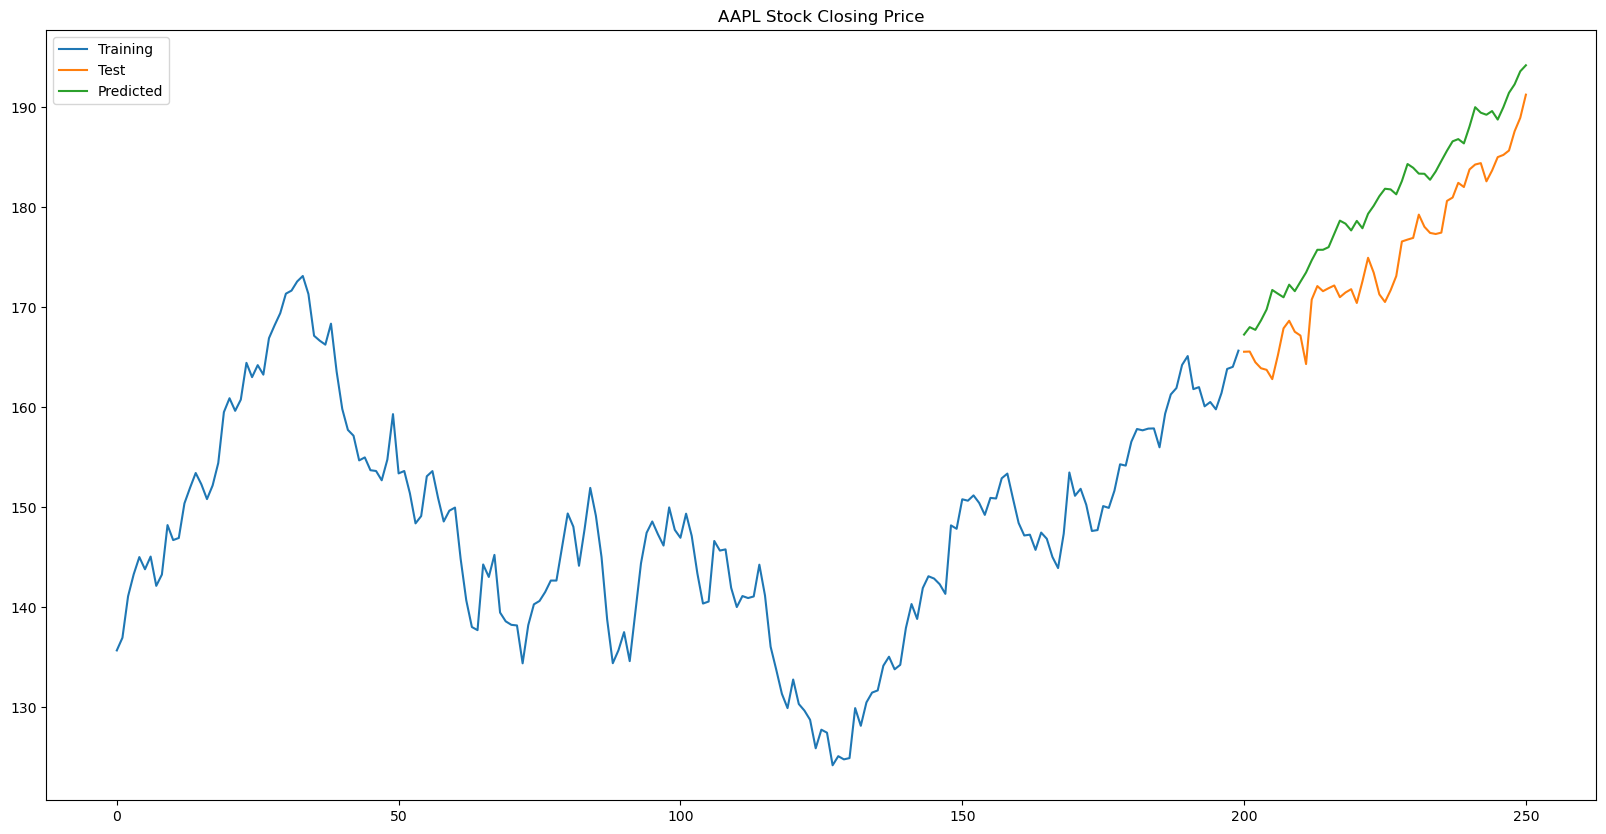

In [19]:
import matplotlib.pyplot as plt

# Create a DataFrame for the predicted values
# prediction = pd.DataFrame(arima_model.predict(n_periods = len(test)), index = test.index)
# prediction.columns = ['Close']
# forecast_result = model_fit.forecast(steps=len(test))
# # Create a new series with predictions
# forecast_series = pd.Series(forecast_result.values, index=test.index)
# model_fit = arima_model.fit()
# forecast_result = model_fit.forecast(steps=len(test))
# forecast_series = pd.Series(forecast_result.values, index=test.index)
# print(forecast_series)

data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

# Use the model to make predictions
forecast_result = arima_model.predict(n_periods=len(test))

# Create a series with the predictions
forecast_series = pd.Series(forecast_result.values, index=test.index)

print(forecast_series)

# Plot the results
plt.figure(figsize=(20,10))
plt.plot(train, label="Training")
plt.plot(test, label="Test")
plt.plot(forecast_series, label="Predicted")
plt.title("AAPL Stock Closing Price")
plt.legend(loc='best')
plt.show()
